## Capstone Project - IBM Data Science Certification on Coursera
### Brad Mills

## Introduction

Identifying Food and Healthcare Deserts and their potential Impact.

Using location data obtained via the Foursquare API to locate area schools and the businesses in their surrounding neighborhoods.  Defining neighborhoods as having a risk potential for becoming a food and/or healthcare desert from this live location data using both a simple catagorization scheme and an unsupervised machine learning approach, and then evaluating if there appears to be a correlation between these designations and linked graduation rate data read from the Indiana Department of Education's website.

## Table of Contents

<div class="alert alert-block alert-info" style="margin-top: 20px">
<font size = 3>

1. <a href="#item1">Use Foursquare API to locate Indianapolis area High Schools</a>

2. <a href="#item2">Data Cleanup</a>

3. <a href="#item3">Use Indiana DOE website to load a Graduation Rates spreadsheet</a>

4. <a href="#item4">Link the two data sources</a>

5. <a href="#item5">Identify school neighborhoods as Food and/or Healthcare deserts</a>

6. <a href="#item6">Assess correlation between the 2 datasets using simple categorization</a>

7. <a href="#item7">Cluster similar neighborhoods using K-means</a>

8. <a href="#item8">Assess correlation between the 2 datasets using ML</a>

</font>
</div>

Load standard and specialized libraries

In [1]:
# for data structures and math
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# for plotting
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('ggplot')

# for http requests and JSON
import requests
import json

# for translating addresses and postal codes to latitude/longitude
from geopy.geocoders import Nominatim
import geocoder

# for map rendering
import folium

# for map marker color palette
import matplotlib.cm as cm
import matplotlib.colors as colors

# for clustering
from sklearn.cluster import KMeans

# for regular expression searches
import re

print('Libraries imported.')

Libraries imported.


<a id='item1'></a>

## 1. Use Foursquare API to locate Indianapolis area High Schools

Define a user_agent to look up initial central city map coordiantes

In [2]:
CITY  = 'Indianapolis'  # breaking out for portability and to use as a potential filter
state = 'Indiana'
address = CITY + ', ' + state

geolocator = Nominatim(user_agent="city_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geographical coordinates for {} are {}, {}.'.format(CITY, latitude, longitude))

The geographical coordinates for Indianapolis are 39.7683331, -86.1583502.


In [3]:
# Foursquare credentials and identifiers

CLIENT_ID = 'Y3MVHWR3QCOO3UAIXS2BHXRPMLPQFN4ILS50KNTHQ0EIZHFR'
CLIENT_SECRET = '2IRGGGVZ5MDPUVDJDRWAJVZ5BNPM2HRXWS3ONOJNEWRYSMNK' # reset after submitting assignment
VERSION = '20180605' # Foursquare API version


In [4]:
# Use Foursquare location data to identify High Schools within a 15 mile radius

HighSchool = '4bf58dd8d48988d13d941735'  # Foursquare category

LIMIT = 100  # limit of number of venues returned by Foursquare API
radius = 24000  # define radius (in Meters) - approx. 15 mile radius

# create URL
sch_url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    radius, 
    LIMIT,
    HighSchool
)

In [5]:
# send an HTTP request
results = requests.get(sch_url).json()

In [6]:
# parse returned JSON format
schools = results['response']['groups'][0]['items']
details = pd.json_normalize(schools)  # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.location.postalCode', 'venue.location.formattedAddress', 'venue.location.lat', 'venue.location.lng']
city_schools = details.loc[:, filtered_columns]
city_schools.head()


,venue.name,venue.location.postalCode,venue.location.formattedAddress,venue.location.lat,venue.location.lng
0,Decatur Central High School,46221,"[5251 Kentucky Ave (at Gatwick Dr), Indianapol...",39.687814,-86.275718
1,Greenwood Community High School,46143,"[650 W Smith Valley Rd., Greenwood, IN 46143, ...",39.602884,-86.116524
2,The Excel Center,46222,"[1635 W Michigan St, Indianapolis, IN 46222, U...",39.773974,-86.191050
3,Purdue Polytechnic High School,46225,"[525 S Meridian St, Indianapolis, IN 46225, Un...",39.759338,-86.157919
4,Crispus Attucks Medical Magnet HS,46202,"[1000 N. MLK Blvd, Indianapolis, IN 46202, Uni...",39.782720,-86.169074


<a id='item2'></a>

## 2. Data Cleaning

Define a series of functions to help filter and standardize school names between the two datasets

In [7]:
# Since we're focusing on public schools, a boolean function to flag non-traditional school names
# that may indicate additional resources or focus not afforded most neighborhood schools

def nonTraditional(name):
    name = name.upper()
    
    if 'UNIVERSITY' in name:
        return True
    if 'MAGNET' in name:
        return True
    if 'ACADEMY' in name:
        return True
    
    return False    

In [8]:
# One of two functions to standardize school names to account for common differences between our two sources,
# e.g. School abbreviated as Sch, the addition of Community or Comm in the name

# For the Graduation Rate dataframe, will add additional entries to increase potential linkage rate

def grtStandardize(name):
    orig = name
    
    # expand Sch to School
    name = re.sub('Sch$', 'School', name)
    
    # expand HS to High School
    name = re.sub('HS$', 'High School', name)
    
    # remove Community or Comm (in that order)
    if re.search('Community ', name):
        name = re.sub('Community ', '', name)
    else:
        name = re.sub('Comm ', '', name)

    # remove Junior-Senior, Junior/Senior, Jr-Sr, Jr/Sr, and Jr & Sr variants
    if re.search('Junior.Senior ', name):
        name = re.sub('Junior.Senior ', '', name)
    else:
        name = re.sub('Jr.{1,3}Sr ', '', name)   
 
    # remove Senior or Sr
    if re.search('Senior ', name):
        name = re.sub('Senior ', '', name)
    else:
        name = re.sub('Sr ', '', name)   
    
    return name != orig, name  

In [9]:
# Second of two function sets to standardize school names to account for common differences between our two sources,
# e.g. The addition of Community or Comm in the name, duplication of the city name at beginning, extraneous or missing info

# For the names found via the Foursquare API, will change entry and try a few options to increase the potential linkage rate

def fsqStandardize(name):
    orig = name
    
    # expand HS to High School
    name = re.sub('HS$', 'High School', name)
    
    # expand Tech to Technical
    name = re.sub('Tech ', 'Technical ', name)

    # remove Community or Comm (in that order)
    if re.search('Community ', name):
        name = re.sub('Community ', '', name)
    else:
        name = re.sub('Comm ', '', name)
 
    # add High School if missing at end
    if not re.search('High School$', name):
        name = name + ' High School'

    # remove any extraneous info after High School
    s = re.split(' High School', name)
    if len(s) > 1 and s[1] != '':
        name = s[0] + ' High School'
        
    return name != orig, name


# Function to remove the city from the name, if applicable, as a second attempt at linking sources

def woCity(name):
    orig = name

    # using global city constant defined above
    expr = '^{} '.format(CITY)    
    name = re.sub(expr, '', name)
    
    return name != orig, name

In [10]:
# Function to categorize neighborhoods into likely distance feasible to travel for basic needs,
# based on distance from initial inner city search or a Corporation override

def askPythagoras(lat, lng, corp='', THRESHOLD=0.16):
    # optional argument to auto assign CITY or Municipal School District schools to Urban
    expr = '^\s*M S D|{}'.format(CITY)
    if re.search(expr, corp):
        return 'Urban'
    
    latd = lat - latitude  # distance from inner CITY
    lngd = lng - longitude
    dist = np.sqrt(latd**2 + lngd**2)
    
    if (dist < THRESHOLD):
        return 'Urban'
    else:
        return 'Rural'

<a id='item3'></a>

## 3. Use Indiana DOE website to load a Graduation Rates spreadsheet

Using DOE spreadsheet to both grab Graduation Rates and verify that a school is active and public

In [11]:
xref = pd.read_excel('https://www.doe.in.gov/sites/default/files/accountability/2019-state-grad-rate-data-20191231.xlsx', sheet_name='School Public NonWaiver', header=1)
xref.head()

,Corp Id,CORPORATION NAME,School Id,SCHOOL NAME,Cohort N,Grad N,2019 State Grad Rate,Non-Waiver Grad N,2019 State Non-Waiver Grad Rate
0,15,Adams Central Community Schools,21,Adams Central High School,99,98,0.9899,95,0.9596
1,25,North Adams Community Schools,29,Bellmont Senior High School,173,160,0.9249,146,0.8439
2,35,South Adams Schools,23,South Adams High School,73,63,0.863,56,0.7671
3,125,M S D Southwest Allen County Schls,47,Homestead Senior High School,578,547,0.9464,528,0.9135
4,225,Northwest Allen County Schools,91,Carroll High School,583,560,0.9605,547,0.9383


In [12]:
# Expand cross reference by adding alternative rows with standardized names to improve linking

for i, row in xref.iterrows():
    upd, std_name = grtStandardize(row['SCHOOL NAME'])
    if upd:
        row['SCHOOL NAME'] = std_name
        xref = xref.append(row)

In [13]:
# delete any added duplicate alternatives based on School Name

xref.drop_duplicates(subset='SCHOOL NAME', keep='first', inplace=True) 
xref.shape

(534, 9)

<a id='item4'></a>

## 4. Link the two data sources

Comparing the initial list of schools to the cross reference created in the step above.  Keeping several fields from each source. The schools in this new dataframe will serve as the center points for defining neighborhoods.

In [14]:
vlist = []  # capturing related matched values as tuples in a temporary list

for i, row in city_schools.iterrows():
    # Clean up / Standardize the school names here as well before linking
    upd, std_name = fsqStandardize(row['venue.name'])
    
    # exclude indicators of a nonTraditional school from the analysis   
    if nonTraditional(std_name):
        continue
    
    # Check for a match against the graduation rate cross reference    
    grt = xref.loc[xref['SCHOOL NAME'] == std_name]['2019 State Non-Waiver Grad Rate']
    if grt.shape[0]:
        match = True
    else:
        match = False        
        # try an additional step of removing city references from the school names
        upd, std_name = woCity(std_name)
        grt = xref.loc[xref['SCHOOL NAME'] == std_name]['2019 State Non-Waiver Grad Rate']
        if grt.shape[0]:
            match = True
    
    # add field values for successfully linked records to a temporary list as tuples    
    if match:
        name = re.sub(' High School$', '', std_name)  # shorten display length by removing common ending
        grad_rate = np.float(grt)
        
        # retrieve other potential values of interest/utility      
        ref = xref.loc[xref['SCHOOL NAME'] == std_name]
        lat = row['venue.location.lat']
        lng = row['venue.location.lng']
        class_sz = np.int(ref['Cohort N'])
        corp = ref['CORPORATION NAME'].to_string().split('    ')[1]
        zipcd = row['venue.location.postalCode']
        addr = row['venue.location.formattedAddress']
        stg = askPythagoras(lat, lng, corp)

        vlist.append((name, lat, lng, stg, grad_rate, class_sz, corp))
            
# convert final list of matched values to a dataframe and remove any duplicates rows    
hub_schools = pd.DataFrame(vlist, columns=('School', 'Latitude', 'Longitude', 'Setting', 'GradRate', 'ClassSize', 'Corporation'))
hub_schools.drop_duplicates(subset='School', keep='first', inplace=True) 
hub_schools.head()

,School,Latitude,Longitude,Setting,GradRate,ClassSize,Corporation
0,Decatur Central,39.687814,-86.275718,Urban,0.7257,412,M S D Decatur Township
1,Greenwood,39.602884,-86.116524,Rural,0.8611,288,Greenwood Community Sch Corp
2,Crispus Attucks,39.782697,-86.169893,Urban,0.8685,213,Indianapolis Public Schools
3,Arsenal Technical,39.776575,-86.133930,Urban,0.7736,605,Indianapolis Public Schools
4,Herron,39.789116,-86.155428,Urban,0.9474,209,Herron Charter


In [15]:
# display initial map of schools discovered via Foursquare API

city_map = folium.Map(location=[latitude, longitude], zoom_start=10)

# set up a broad color scheme
cnt = 2
x = np.arange(cnt)
ys = [i + x + (i*x)**2 for i in range(cnt)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# assign color based on school/neighborhood setting
def shade(setting):
    if setting == 'Urban':
        return rainbow[0]
    else:
        return rainbow[1]
    

# add markers to the map
for lat, lng, poi, stg in zip(hub_schools['Latitude'], hub_schools['Longitude'], hub_schools['School'], hub_schools['Setting']):
    label = folium.Popup(str(poi) + ' : ' + str(stg), parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=shade(stg),
        fill=True,
        fill_color=shade(stg),
        fill_opacity=0.7).add_to(city_map)
       
city_map

<a id='item5'></a>

## 5. Identify school neighborhoods as Food and/or Healthcare deserts

One of the key concepts behind the Food or Healthcare desert definition is that it is only reasonable and feasible for residents to travel a short distance for basic needs.  The distance that is feasible often depends on whether a person has a car or depends on public transportation (or walking).

In [16]:
# Function to define the reasonable distance to travel for food or healthcare.
# Uses a smaller value for Urban settings where folks might not have access
# to their own vehicle.  Could be set to the same value.

def travDist(setting, multiplier=3, base=1000):
    # base radius distance is in Meters
    
    if setting == 'Urban':
        return base
    else:  # Rural or Suburban
        return multiplier * base


In [17]:
# Medical category IDs for Foursquare API

DoctorsOffice = '4bf58dd8d48988d177941735'
MaternityClinic = '56aa371be4b08b9a8d5734ff'
MentalHealthOffice ='52e81612bcbc57f1066b7a39'
Pharmacy = '4bf58dd8d48988d10f951735'
Hospital = '4bf58dd8d48988d196941735'
EmergencyRoom = '4bf58dd8d48988d194941735'
UrgentCareCenter = '56aa371be4b08b9a8d573526'

medcat  = ['DoctorsOffice', 'MaternityClinic', 'MentalHealthOffice', 'Pharmacy', 'Hospital', 'EmergencyRoom', 'UrgentCareCenter']
medical = [DoctorsOffice, MaternityClinic, MentalHealthOffice, Pharmacy, Hospital, EmergencyRoom, UrgentCareCenter]
medstr = ','.join(medical)

In [18]:
# Food and Nutrition category IDs for Foursquare API

Supermarket = '52f2ab2ebcbc57f1066b8b46'
GroceryStore = '4bf58dd8d48988d118951735'
OrganicGrocery = '52f2ab2ebcbc57f1066b8b45'
FarmersMarket = '4bf58dd8d48988d1fa941735'

grocat = ['Supermarket', 'GroceryStore', 'OrganicGrocery', 'FarmersMarket']
groc = [Supermarket, GroceryStore, OrganicGrocery, FarmersMarket]
grocstr = ','.join(groc)

In [19]:
# Function to return a data frame of nearby medical or grocery venues, based on the passed venue categories
# Will loop through all schools of interest when passed as lists

def getNearbyVenues(names, latitudes, longitudes, settings, cat_str, multiplier=3, base=1000):
    LIMIT = 100  # need the extra capacity of explore operator
    
    venues_list=[]
    for name, lat, lng, stg in zip(names, latitudes, longitudes, settings):
        print(name)

        # add a flexible radius for Urban vs Rural setting
        radius = travDist(stg, multiplier)
        
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT,
            cat_str)

        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name,
            stg,
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood',
                  'Setting',
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude',
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [20]:
med_venues = getNearbyVenues(hub_schools['School'],
                             hub_schools['Latitude'],
                             hub_schools['Longitude'],
                             hub_schools['Setting'],
                             medstr
                            )
med_venues.head()

Decatur Central
Greenwood
Crispus Attucks
Arsenal Technical
Herron
Indianapolis Metropolitan
George Washington
Emmerich Manual
Thomas Carr Howe
Beech Grove
Speedway
Southport
Ben Davis
Shortridge
Lawrence Central
Perry Meridian
Warren Central
Pike
North Central
Franklin Central
Lawrence North
Avon
Brownsburg
Plainfield
New Palestine
Zionsville
Carmel
Center Grove


,Neighborhood,Setting,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Decatur Central,Urban,39.687814,-86.275718,Wesley G. Lackey MD-Midwest Center for Joint R...,39.687837,-86.280184,Doctor's Office
1,Decatur Central,Urban,39.687814,-86.275718,Richard W. Jackson MD-Midwest Center for Joint...,39.687771,-86.280205,Doctor's Office
2,Decatur Central,Urban,39.687814,-86.275718,Midwest Specialty Surgery Center,39.687575,-86.281323,Hospital
3,Decatur Central,Urban,39.687814,-86.275718,Joshua L. Carter MD-Midwest Center for Joint R...,39.687710,-86.281662,Doctor's Office
4,Decatur Central,Urban,39.687814,-86.275718,Michael E. Berend MD-Midwest Center for Joint ...,39.687710,-86.281662,Doctor's Office


In [21]:
med_venues.shape

(595, 8)

In [22]:
groc_venues = getNearbyVenues(hub_schools['School'],
                              hub_schools['Latitude'],
                              hub_schools['Longitude'],
                              hub_schools['Setting'],
                              grocstr,
                              multiplier=5,
                              base=1600
                              )
groc_venues.head()

Decatur Central
Greenwood
Crispus Attucks
Arsenal Technical
Herron
Indianapolis Metropolitan
George Washington
Emmerich Manual
Thomas Carr Howe
Beech Grove
Speedway
Southport
Ben Davis
Shortridge
Lawrence Central
Perry Meridian
Warren Central
Pike
North Central
Franklin Central
Lawrence North
Avon
Brownsburg
Plainfield
New Palestine
Zionsville
Carmel
Center Grove


,Neighborhood,Setting,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Decatur Central,Urban,39.687814,-86.275718,Los Patios Mexican Store,39.694170,-86.269020,Grocery Store
1,Greenwood,Rural,39.602884,-86.116524,Aldi,39.594531,-86.101949,Supermarket
2,Greenwood,Rural,39.602884,-86.116524,Gordon Food Service,39.627259,-86.121817,Grocery Store
3,Greenwood,Rural,39.602884,-86.116524,Kroger,39.584052,-86.102857,Supermarket
4,Greenwood,Rural,39.602884,-86.116524,Fresh Thyme Farmers Market,39.638519,-86.130807,Grocery Store


In [23]:
groc_venues.shape

(99, 8)

In [24]:
# groupby counts
med_venues.groupby('Neighborhood').count().head()

,Setting,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,,
Arsenal Technical,13,13,13,13,13,13,13
Avon,22,22,22,22,22,22,22
Ben Davis,4,4,4,4,4,4,4
Brownsburg,21,21,21,21,21,21,21
Carmel,100,100,100,100,100,100,100


In [25]:
# groupby counts
groc_venues.groupby('Neighborhood').count().head()

,Setting,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,,
Arsenal Technical,2,2,2,2,2,2,2
Avon,15,15,15,15,15,15,15
Brownsburg,4,4,4,4,4,4,4
Carmel,16,16,16,16,16,16,16
Center Grove,6,6,6,6,6,6,6


In [26]:
print('There are {} unique med categories.'.format(len(med_venues['Venue Category'].unique())))
print('There are {} unique groc categories.'.format(len(groc_venues['Venue Category'].unique())))

There are 17 unique med categories.
There are 10 unique groc categories.


In [27]:
# one hot encoding (setting category flags)
med_onehot = pd.get_dummies(med_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
med_onehot['Neighborhood'] = med_venues['Neighborhood']
med_onehot.head()

,Assisted Living,Big Box Store,Dentist's Office,Doctor's Office,Emergency Room,Grocery Store,Home Service,Hospital,Hospital Ward,Medical Center,Mental Health Office,Optical Shop,Parking,Pharmacy,Supermarket,Urgent Care Center,Veterinarian,Neighborhood
0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,Decatur Central
1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,Decatur Central
2,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,Decatur Central
3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,Decatur Central
4,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,Decatur Central


In [28]:
# More clean up - drop category columns not in the original medical list

# Returns True if category matches our original medical list (or 'Neighborhood')
def inMed(category):
    if category == 'Neighborhood':
        return True
    
    # remove punctuation and spaces from passed column names
    category = re.sub('\'', '', category)
    category = re.sub(' ', '', category, 2)
    
    if category in medcat:
        return True
    else:
        return False
    
# build list of extraneous columns not in original medical list
lst = []
for col in med_onehot.columns:
    if not inMed(col):
        lst.append(col)

# drop extraneous columns
med_onehot.drop(lst, axis=1, inplace=True)

# AND rows no longer with any 1's
lst = []
for i, row in med_onehot.iterrows():
    if row.iloc[:-1].sum() == 0:
        lst.append(i)
med_onehot.drop(lst, axis=0, inplace=True)

In [29]:
# Group rows by neighborhood and calculate the count for each category

med_grouped_cnt = med_onehot.groupby('Neighborhood').sum().reset_index()
med_grouped_cnt.head()

,Neighborhood,Doctor's Office,Emergency Room,Hospital,Mental Health Office,Pharmacy,Urgent Care Center
0,Arsenal Technical,13,0,0,0,0,0
1,Avon,18,0,1,0,3,0
2,Ben Davis,0,1,1,0,2,0
3,Brownsburg,15,0,0,0,3,1
4,Carmel,86,1,5,2,6,0


In [30]:
# find missing rows for hub schools that returned 0 results from venue search (likely deserts)

vlst = []  # creating tuples in a temporary list

for _, row in hub_schools.iterrows():
    # Check for a match against the count table    
    match = med_grouped_cnt.loc[med_grouped_cnt['Neighborhood'] == row['School']]
    if not match.shape[0]:
        vlst.append((row['School'], 0, 0, 0, 0, 0, 0))
        print(row['School'])
        
# append missing 0 value rows
med_grouped_cnt = med_grouped_cnt.append(pd.DataFrame(vlst, columns=med_grouped_cnt.columns), ignore_index=True)
med_grouped_cnt.tail()

Beech Grove


,Neighborhood,Doctor's Office,Emergency Room,Hospital,Mental Health Office,Pharmacy,Urgent Care Center
23,Speedway,2,0,1,0,0,0
24,Thomas Carr Howe,1,0,0,0,1,0
25,Warren Central,7,0,0,0,0,0
26,Zionsville,24,0,3,0,2,0
27,Beech Grove,0,0,0,0,0,0


In [31]:
# add a Total column to the counts dataframe

med_grouped_cnt.reset_index()
med_grouped_cnt['Total'] = med_grouped_cnt.sum(axis=1)
med_grouped_cnt.head()

,Neighborhood,Doctor's Office,Emergency Room,Hospital,Mental Health Office,Pharmacy,Urgent Care Center,Total
0,Arsenal Technical,13,0,0,0,0,0,13
1,Avon,18,0,1,0,3,0,22
2,Ben Davis,0,1,1,0,2,0,4
3,Brownsburg,15,0,0,0,3,1,19
4,Carmel,86,1,5,2,6,0,100


Repeat similar process for food-based venues

In [32]:
# one hot encoding (generating category flags)
groc_onehot = pd.get_dummies(groc_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
groc_onehot['Neighborhood'] = groc_venues['Neighborhood']
groc_onehot.head()

,American Restaurant,Farmers Market,Food & Drink Shop,Gourmet Shop,Grocery Store,Health Food Store,Organic Grocery,Pharmacy,Sporting Goods Shop,Supermarket,Neighborhood
0,0,0,0,0,1,0,0,0,0,0,Decatur Central
1,0,0,0,0,0,0,0,0,0,1,Greenwood
2,0,0,0,0,1,0,0,0,0,0,Greenwood
3,0,0,0,0,0,0,0,0,0,1,Greenwood
4,0,0,0,0,1,0,0,0,0,0,Greenwood


In [33]:
# Same clean up for food/grocery venues - drop category columns not in the original list

# Returns True if category matches our original food-based list (or 'Neighborhood')
def inGroc(category):
    if category == 'Neighborhood':
        return True
    
    # remove punctuation and spaces from passed column names
    category = re.sub('\'', '', category)
    category = re.sub(' ', '', category, 2)
    
    if category in grocat:
        return True
    else:
        return False
    
# build list of extraneous columns not in original food-based list
lst = []
for col in groc_onehot.columns:
    if not inGroc(col):
        lst.append(col)

# drop extraneous columns
groc_onehot.drop(lst, axis=1, inplace=True)

# AND rows no longer with any 1's
lst = []
for i, row in groc_onehot.iterrows():
    if row.iloc[:-1].sum() == 0:
        lst.append(i)
groc_onehot.drop(lst, axis=0, inplace=True)

In [34]:
# Group rows by neighborhood and calculate the count for each category

groc_grouped_cnt = groc_onehot.groupby('Neighborhood').sum().reset_index()
groc_grouped_cnt.head()

,Neighborhood,Farmers Market,Grocery Store,Organic Grocery,Supermarket
0,Arsenal Technical,2,0,0,0
1,Avon,1,4,1,8
2,Brownsburg,0,1,1,2
3,Carmel,2,8,1,4
4,Center Grove,0,3,0,3


In [35]:
# find missing rows for hub schools that returned 0 results from venue search (likely deserts)

vlst = []  # creating tuples in a temporary list

for _, row in hub_schools.iterrows():
    # Check for a match against the count table
    match = groc_grouped_cnt.loc[groc_grouped_cnt['Neighborhood'] == row['School']]
    if not match.shape[0]:
        vlst.append((row['School'], 0, 0, 0, 0))
        
# append 0 value rows
groc_grouped_cnt = groc_grouped_cnt.append(pd.DataFrame(vlst, columns=groc_grouped_cnt.columns), ignore_index=True)
groc_grouped_cnt.tail()

,Neighborhood,Farmers Market,Grocery Store,Organic Grocery,Supermarket
23,Shortridge,0,0,0,0
24,Lawrence Central,0,0,0,0
25,Perry Meridian,0,0,0,0
26,Warren Central,0,0,0,0
27,Pike,0,0,0,0


In [36]:
# add a Total column to the count dataframe

groc_grouped_cnt.reset_index()
groc_grouped_cnt['Total'] = groc_grouped_cnt.sum(axis=1)
groc_grouped_cnt.head()

,Neighborhood,Farmers Market,Grocery Store,Organic Grocery,Supermarket,Total
0,Arsenal Technical,2,0,0,0,2
1,Avon,1,4,1,8,14
2,Brownsburg,0,1,1,2,4
3,Carmel,2,8,1,4,15
4,Center Grove,0,3,0,3,6


<a id='item6'></a>

## 6. Assess correlation between the 2 datasets using simple categorization

#### My (supervised) take on assigning H/M/L categorization to the count values
#### Will turn to an unsupervised clustering method in the next section

In [37]:
# Sort dataframes following previous manipulations in preparation for
# linking in location coordinates, graduation rates, etc.

# sorting steps for hub school cross reference
hub_schools.sort_values('School', inplace=True)
hub_schools.reset_index(drop=True, inplace=True)
# and for venue counts dataframes
med_grouped_cnt.sort_values('Neighborhood', inplace=True)
med_grouped_cnt.reset_index(drop=True, inplace=True)
groc_grouped_cnt.sort_values('Neighborhood', inplace=True)
groc_grouped_cnt.reset_index(drop=True, inplace=True)

In [38]:
# Assign a Medical Desert Risk Indicator based on venue counts data from each school/neighborhood

def medDesertRiskIndicator(row):
    # essentially grouping neighborhoods by single, double, or near-triple digit counts
    # counts are capped at 100 results by Foursquare API
    vcnt = row['Total']
    if vcnt < 10:
        return 'High'
    if vcnt < 90:
        return 'Medium'
    # otherwise
    return 'Low'

# add categorical column indicator to the counts dataframe
med_grouped_cnt['Medical Desert Risk Indicator'] = med_grouped_cnt.apply(medDesertRiskIndicator, axis=1)
med_grouped_cnt.head()

,Neighborhood,Doctor's Office,Emergency Room,Hospital,Mental Health Office,Pharmacy,Urgent Care Center,Total,Medical Desert Risk Indicator
0,Arsenal Technical,13,0,0,0,0,0,13,Medium
1,Avon,18,0,1,0,3,0,22,Medium
2,Beech Grove,0,0,0,0,0,0,0,High
3,Ben Davis,0,1,1,0,2,0,4,High
4,Brownsburg,15,0,0,0,3,1,19,Medium


In [39]:
# Assign a Food Desert Risk Indicator based on venue counts data from each school/neighborhood

# lower overall counts, so using percentiles as an inital approach
Q25, Q75 = np.percentile(groc_grouped_cnt['Total'], [25 ,75])

def foodDesertRiskIndicator(row):
    vcnt = row['Total']
    if vcnt <= Q25:
        return 'High'
    if vcnt > Q75:
        return 'Low'
    # otherwise
    return 'Medium'

# add categorical column indicator to the counts dataframe
groc_grouped_cnt['Food Desert Risk Indicator'] = groc_grouped_cnt.apply(foodDesertRiskIndicator, axis=1)
groc_grouped_cnt.head()

,Neighborhood,Farmers Market,Grocery Store,Organic Grocery,Supermarket,Total,Food Desert Risk Indicator
0,Arsenal Technical,2,0,0,0,2,Medium
1,Avon,1,4,1,8,14,Low
2,Beech Grove,0,0,0,0,0,High
3,Ben Davis,0,0,0,0,0,High
4,Brownsburg,0,1,1,2,4,Medium


In [40]:
# pull grad rate into cnt dataframes

med_grouped_cnt['Graduation Rate'] = hub_schools['GradRate']
groc_grouped_cnt['Graduation Rate'] = hub_schools['GradRate']
med_grouped_cnt.head()

,Neighborhood,Doctor's Office,Emergency Room,Hospital,Mental Health Office,Pharmacy,Urgent Care Center,Total,Medical Desert Risk Indicator,Graduation Rate
0,Arsenal Technical,13,0,0,0,0,0,13,Medium,0.7736
1,Avon,18,0,1,0,3,0,22,Medium,0.9130
2,Beech Grove,0,0,0,0,0,0,0,High,0.7269
3,Ben Davis,0,1,1,0,2,0,4,High,0.6995
4,Brownsburg,15,0,0,0,3,1,19,Medium,0.9621


In [41]:
# Function to generate boxplots comparing Graduation Rates to Desert Risk Indicators (food or medical) or clusters

def plotGradRates(df, col, cat):
    ycol = 'Graduation Rate'
    xcol = col
    fig = plt.figure()

    # find and plot to overall y range to allow comparisons
    ymin = min(df[ycol]) - 0.01
    ymax = max(df[ycol]) + 0.01

    fig, axs = plt.subplots(1, len(cat), figsize=(15,10))
    
    # one boxplot per lst item
    for i, lbl in enumerate(cat):
        grt = df.loc[df[xcol] == lbl][ycol]
        axs[i].boxplot(grt, boxprops=dict(color='blue'), whiskerprops=dict(color='blue'),
                            capprops=dict(color='blue'))
        axs[i].set_ylim(ymin, ymax)
        axs[i].set_xlabel('{}={}'.format(col, str(lbl).upper()))
        axs[i].set_xticklabels([])
        #axs[i].scatter(np.ones_like(grt), grt, marker='x', color='blue')  # adds individual datapoints

    # add figure labels
    axs[0].set_ylabel('Graduation Rates')
    axs[len(cat)//2].set_title('Graduation Rates by {}'.format(col))

    plt.show()

<Figure size 432x288 with 0 Axes>

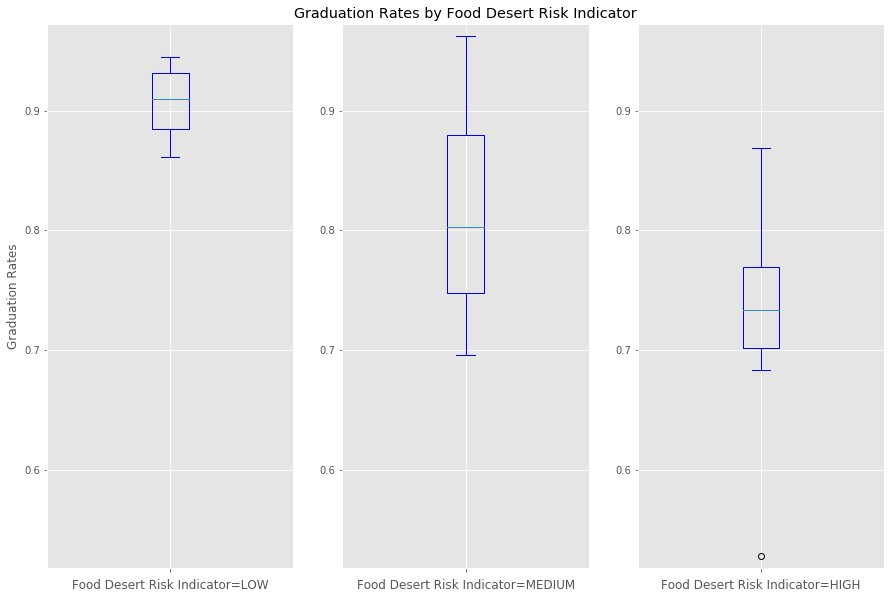

In [42]:
# assess correlation between defined risk indicators and graduation rate
plotGradRates(groc_grouped_cnt, 'Food Desert Risk Indicator', ['Low', 'Medium', 'High'])

<Figure size 432x288 with 0 Axes>

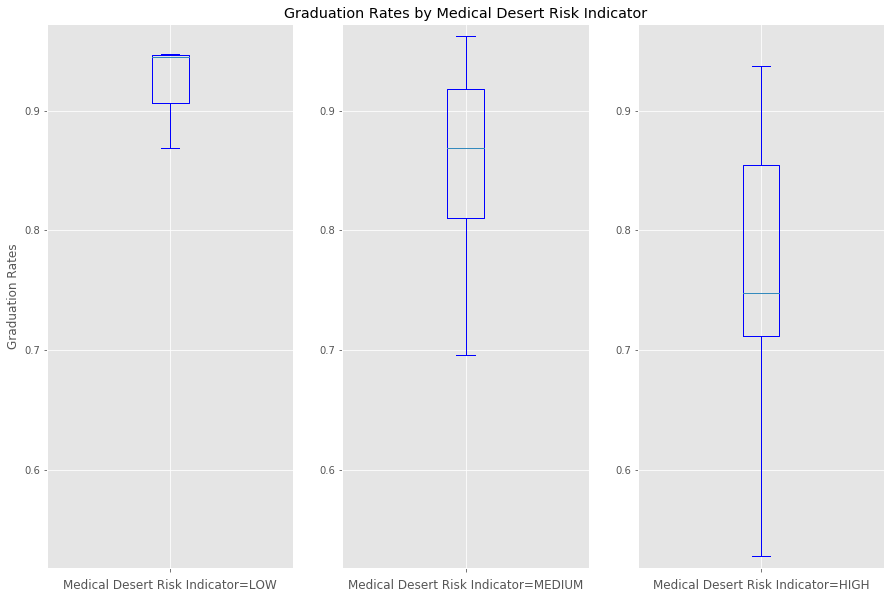

In [43]:
# assess correlation between defined risk indicators and graduation rate
plotGradRates(med_grouped_cnt, 'Medical Desert Risk Indicator', ['Low', 'Medium', 'High'])

Generate a Grocery Map showing low resource (desert) locations

In [44]:
# display Food Desert map based on locations discovered via Foursquare API

groc_map = folium.Map(location=[latitude, longitude], zoom_start=10)

# set up H/M/L category color scheme
cnt = 3
x = np.arange(cnt)
ys = [i + x + (i*x)**2 for i in range(cnt)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# assign color based on H/M/L indicator
def shade(indicator):
    if indicator == 'High':
        return colors.CSS4_COLORS['crimson']
    if indicator == 'Medium':
        return colors.CSS4_COLORS['darkorange']
    # otherwise
    return colors.CSS4_COLORS['forestgreen']
    
# add markers to the map
for lat, lng, poi, fdi, tot in zip(hub_schools['Latitude'], hub_schools['Longitude'], groc_grouped_cnt['Neighborhood'],
                                   groc_grouped_cnt['Food Desert Risk Indicator'], groc_grouped_cnt['Total']):
    label = folium.Popup(str(poi) + ' : Count=' + str(tot), parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=shade(fdi),
        fill=True,
        fill_color=shade(fdi),
        fill_opacity=0.7).add_to(groc_map)
       
groc_map

<a id='item7'></a>

## 7. Cluster similar neighborhoods using K-means

Try a couple of unsupervised ways of clustering the counts data using K-means to see if we can get an even clearer picture of the association between access to nutritional needs and the relationship to education as seen through graduation rates.  The first will use the Totals column as I did above, but will see if there is a better number of clusters than the traditional H/M/L that I used.  The second will use the count breakouts (by store type) to see if that holds any useful information.

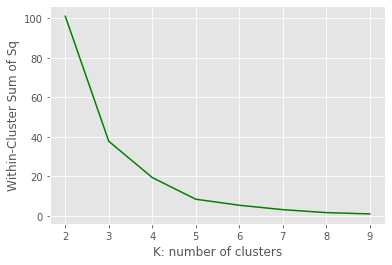

In [45]:
# pick k (number of clusters) to use for the first method by plotting and 
# observing the elbow/inflection point commonly used as a heuristic

# trying multiple values of k
n = 10

# capture and graph the within-cluster sum of squares (distances to Centroid centers) to determine an inflection point
distSS = np.zeros((n-1))

# using only the Total column for this first method
groc_clusters_wrk = groc_grouped_cnt[['Total']].copy()

# run k-means clustering n-1 times
for k in range(2, n):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(groc_clusters_wrk)
    distSS[k-1] = kmeans.inertia_

# plot inertia for tested k values
plt.plot(range(2,n), distSS[1:], 'green')
plt.ylabel('Within-Cluster Sum of Sq')
plt.xlabel('K: number of clusters')
plt.show()

In [46]:
# Using k=5 clusters based on above inflection point

# so running a final time to capture Cluster labels
kmeans = KMeans(n_clusters=5, random_state=0).fit(groc_clusters_wrk)

# replacing Risk Indicator with first clustering method
groc_clusters_m1 = groc_grouped_cnt.drop('Food Desert Risk Indicator', 1)
groc_clusters_m1['Cluster'] = kmeans.labels_

In [47]:
# look at cluster characteristics and save copy for analysis
groc_clusters_wrk_m1 = groc_clusters_wrk.copy()
groc_clusters_wrk_m1['Cluster'] = kmeans.labels_
groc_clusters_wrk_m1.groupby('Cluster').mean()

,Total
Cluster,
0,2.166667
1,15.000000
2,0.285714
3,4.750000
4,9.000000


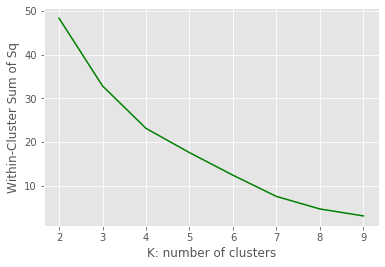

In [48]:
# pick k (number of clusters) to use for the second method

# using the grocery subcategories for this method
groc_clusters_wrk = groc_grouped_cnt.drop(['Neighborhood','Total','Food Desert Risk Indicator','Graduation Rate'], 1)

# with scaling due to multiple columns
from sklearn.preprocessing import StandardScaler
scaled_values = StandardScaler().fit_transform(groc_clusters_wrk)
groc_clusters_wrk_scaled = groc_clusters_wrk.copy()
groc_clusters_wrk_scaled.loc[:,:] = scaled_values

# trying multiple values of k
n = 10

# capture and graph the within-cluster sum of squares (distances to Centroid centers) to determine an inflection point
distSS = np.zeros((n-1))

# run k-means clustering n-1 times
for k in range(2, n):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(groc_clusters_wrk_scaled)
    distSS[k-1] = kmeans.inertia_

# plot inertia for tested k values
plt.plot(range(2,n), distSS[1:], 'green')
plt.ylabel('Within-Cluster Sum of Sq')
plt.xlabel('K: number of clusters')
plt.show()

In [49]:
# Using k=9 clusters based on a series of late inflection point

# so running a final time to capture Cluster labels
kmeans = KMeans(n_clusters=9, random_state=0).fit(groc_clusters_wrk_scaled)

# replacing Risk Indicator with first clustering method
groc_clusters_m2 = groc_grouped_cnt.drop('Food Desert Risk Indicator', 1)
groc_clusters_m2['Cluster'] = kmeans.labels_

In [50]:
# look at cluster characteristics and save copy for analysis
groc_clusters_wrk_m2 = groc_clusters_wrk.copy()
groc_clusters_wrk_m2['Cluster'] = kmeans.labels_
groc_clusters_wrk_m2.groupby('Cluster').mean()

,Farmers Market,Grocery Store,Organic Grocery,Supermarket
Cluster,,,,
0,0.0,0.000000,0.0,0.166667
1,2.0,8.000000,1.0,4.000000
2,0.0,1.666667,0.0,2.666667
3,0.0,2.000000,1.0,3.500000
4,2.0,7.000000,0.0,7.000000
5,2.0,0.000000,0.0,0.000000
6,1.0,4.000000,1.0,8.000000
7,0.0,5.000000,0.0,0.000000
8,0.0,1.333333,0.0,0.333333


In [51]:
# list members of cluster 8
groc_clusters_m2.loc[groc_clusters_m2['Cluster'] == 8]

,Neighborhood,Farmers Market,Grocery Store,Organic Grocery,Supermarket,Total,Graduation Rate,Cluster
8,Decatur Central,0,1,0,0,1,0.7257,8
11,George Washington,0,2,0,0,2,0.7557,8
14,Indianapolis Metropolitan,0,2,0,0,2,0.8226,8
17,New Palestine,0,1,0,0,1,0.8576,8
23,Southport,0,1,0,1,2,0.7122,8
24,Speedway,0,1,0,1,2,0.8615,8


<a id='item8'></a>

## 8. Assess correlation between the 2 datasets using ML

Graph and compare ML clustering results from above to earlier more manual categorization method.

<Figure size 432x288 with 0 Axes>

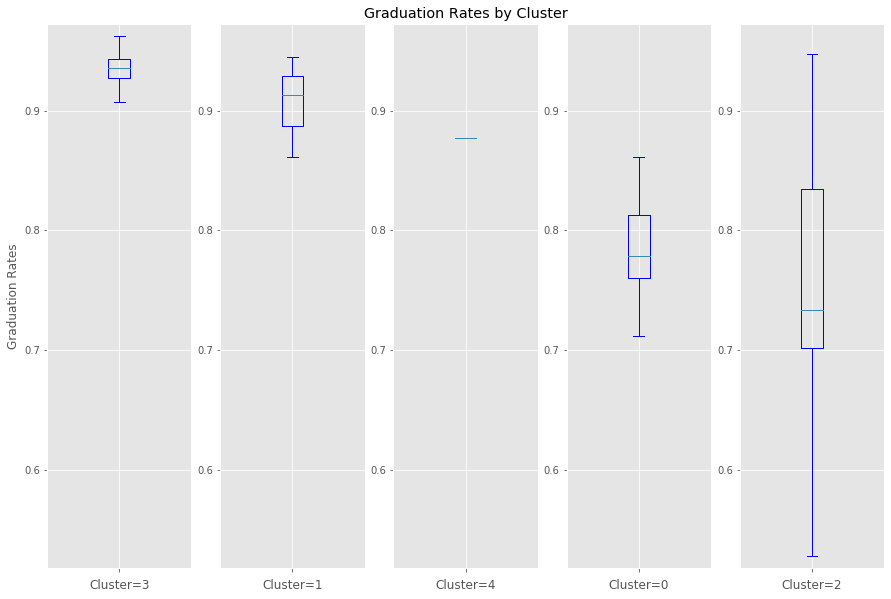

In [52]:
# Clustering method 1 - using Total grocer counts

plotGradRates(groc_clusters_m1, 'Cluster', [3, 1, 4, 0, 2])

<Figure size 432x288 with 0 Axes>

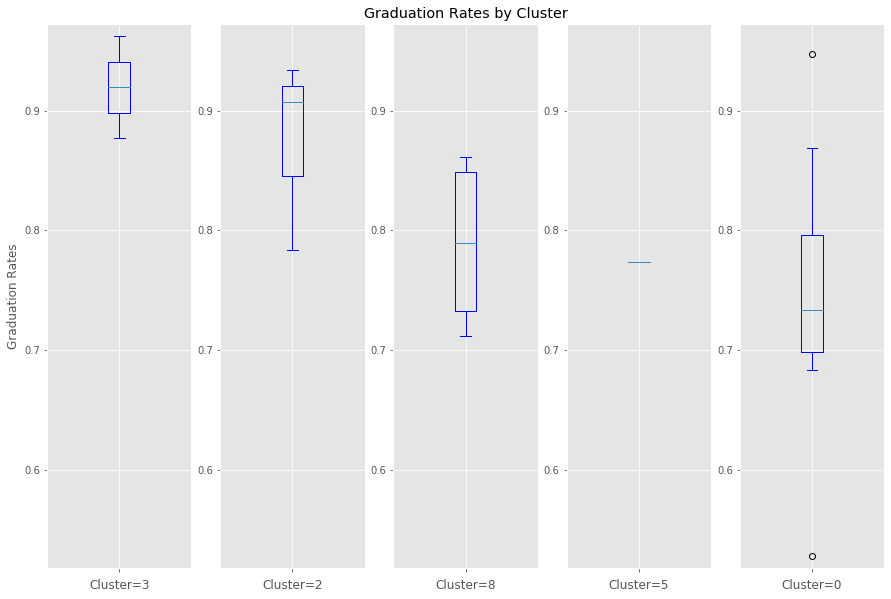

In [53]:
# Clustering method 2 - using grocer subtypes and scaling

plotGradRates(groc_clusters_m2, 'Cluster', [3, 2, 8, 5, 0])